<h1>Ng learning with capacities</h1>

Considering the last results and also taking into consideration that TW and Capacity play a role in the difficulty to solve a CVRPTW problem, this latter should also be considered in the learning stages

In [1]:
import os
import torch
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from random import shuffle
import numpy as np
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from random import sample
from ipywidgets import IntProgress
from IPython.display import display
import time
import torch.nn as nn
import torch.optim as optim
import tqdm
import copy
from sklearn.model_selection import StratifiedKFold, train_test_split

<h3>Get graphs</h3>

In [2]:

data_files_list = ["./export/"+f for f in os.listdir("./export") ]
instance_dict = {}
instance_additionals = {}
set_sizes_dict = {}
for dir_str in data_files_list:
    with open(dir_str, 'r') as text_file:
        cnt = 0
        instance = ""
        for line in text_file:
            if cnt < 9:
                if cnt == 0:
                    instance = line.split()[0]
                    instance_dict[instance] = []
                if cnt == 4:
                    instance_additionals[instance] = []
                    split_line = line.split()
                    instance_additionals[instance].append([int(i) for i in split_line])
                cnt += 1
                continue
            split_line = line.split()
            instance_dict[instance].append([int(i) for i in split_line])
        text_file.close()

ng_dict = {}
cnt = -1
with open("ng_outs.csv", 'r') as text_file:
    for line in text_file:
        if cnt < 2:
            cnt += 1
            continue
        raw_line = line.strip()
        split_line_list = raw_line.split(sep=";")
        instance = split_line_list[3]
        if instance not in ng_dict:
            ng_dict[instance] = [[0 for i in range(101)]]
        ng_dict[instance].append([0] + [int(i) for i in split_line_list[5:-1]])
        set_sizes_dict[instance] = sum(sum(i) for i in ng_dict[instance])
        if len(split_line_list[5:-1]) != 100:
            print("case found for instance "+instance)
    text_file.close()

KeyboardInterrupt: 

<h3>Select appropriate graphs considering difficulty</h3>
Here's a sensitive topic, because the definition of difficulty can be considered by computation, then using Uchoa et al. 2016 should be enough, but also we need small and big Ng-Sets, sample from data distributions and so on. The plan will be then to sample from the easy ones and take all of the difficult ones.

In [3]:
ordered_difficulty = [(k,v) for k,v in set_sizes_dict.items()]
ordered_difficulty = sorted(ordered_difficulty, key=lambda tup: tup[1], reverse=True)
instances_to_add = [ordered_difficulty[i][0] for i in range(0,1000)]
instances_remaining = [ordered_difficulty[i][0] for i in range(1000,len(ordered_difficulty))]
easy_instances = sample(instances_remaining, 2000)
instance_list = instances_to_add + easy_instances

join with new instances

In [4]:
data_files_list = ["./export2/"+f for f in os.listdir("./export2") ]

for dir_str in data_files_list:
    with open(dir_str, 'r') as text_file:
        cnt = 0
        instance = ""
        for line in text_file:
            if cnt < 9:
                if cnt == 0:
                    instance = line.split()[0]
                    instance_dict[instance] = []
                if cnt == 4:
                    instance_additionals[instance] = []
                    split_line = line.split()
                    instance_additionals[instance].append([int(i) for i in split_line])
                cnt += 1
                continue
            split_line = line.split()
            instance_dict[instance].append([int(i) for i in split_line])
        text_file.close()

cnt = -1
with open("ng_outs_JLA.csv", 'r') as text_file:
    for line in text_file:
        if cnt < 1:
            cnt += 1
            continue
        raw_line = line.strip()
        split_line_list = raw_line.split(sep=";")
        instance = split_line_list[3]
        if instance not in ng_dict:
            ng_dict[instance] = [[0 for i in range(101)]]
        ng_dict[instance].append([0] + [int(i) for i in split_line_list[5:]])
        set_sizes_dict[instance] = sum(sum(i) for i in ng_dict[instance])
        # add new instances
        instance_list.append(instance)
        if len(split_line_list[5:]) != 100:
            print("case found for instance "+instance)
    text_file.close()

<h3>Prepare graphs for Encoding-Decoding routine</h3>

In [5]:
data_list = []
aux_data_list = []


for instance_name in instance_list:
    instance = instance_dict[instance_name]
    attr = []
    for i in instance:
        attr.append(i[1:])
    y = torch.tensor(ng_dict[instance_name], dtype=torch.float)
    x = nn.functional.normalize( torch.tensor(attr, dtype=torch.float) )
    pos = []
    tw_sets_dict = {}
    for i in instance:
        pos.append([i[1], i[2]])
    pos = torch.tensor(pos, dtype=torch.double)
    edge_index = knn_graph(pos, 15)
    data_list.append(Data(x=x, y=y, edge_index=edge_index, pos=pos))
    aux_data_list.append(instance_additionals[instance_name])

In [6]:
ng_dict = {}
instance_dict = {}

In [7]:
def add_edge_labels(graph):
    transform = T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False)
    return transform(graph)

labeled_graphs = [add_edge_labels(graph) for graph in data_list]
shuffle(labeled_graphs)

train_size = [g[0] for g in labeled_graphs]
val_size = [g[1] for g in labeled_graphs]
test_size = [g[2] for g in labeled_graphs]

train_loader = DataLoader(train_size, batch_size=100, shuffle=True)
val_loader = DataLoader(val_size, batch_size=100, shuffle=False)
test_loader = DataLoader(test_size, batch_size=100, shuffle=False)

In [8]:
labeled_graphs = []
train_size = []
val_size = []
test_size = []

<h3>Encoding-Decoding</h3>

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        # self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        # x = self.conv2(x, edge_index).relu()
        # x = self.conv3(x, edge_index).relu()
        return self.conv4(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [10]:
model_ed = Net(data_list[0].num_features, 64, 32).to(device)
optimizer = torch.optim.Adam(params=model_ed.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [11]:
def train(loader, epoch):
    model_ed.train()
    total_loss = 0

    if epoch == 8:
        for g in optimizer.param_groups:
            g['lr'] = 0.001

    for batch in loader:
        optimizer.zero_grad()
        z = model_ed.encode(batch.x, batch.edge_index)

        # We perform a new round of negative sampling for every training epoch:
        neg_edge_index = negative_sampling(
            edge_index=batch.edge_index, num_nodes=batch.num_nodes,
            num_neg_samples=batch.edge_label_index.size(1), method='sparse')

        # Concat positive and negative edge indices.
        edge_label_index = torch.cat(
            [batch.edge_label_index, neg_edge_index],
            dim=-1,
        )
        # Label for positive edges: 1, for negative edges: 0.
        edge_label = torch.cat([
            batch.edge_label,
            batch.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        # Note: The model is trained in a supervised manner using the given
        # `edge_label_index` and `edge_label` targets.
        out = model_ed.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def test(loader):
    model_ed.eval()
    all_out = []
    all_labels = []

    for batch in loader:
        z = model_ed.encode(batch.x, batch.edge_index)
        out = model_ed.decode(z, batch.edge_label_index).view(-1).sigmoid()
        all_out.append(out.cpu().numpy())
        all_labels.append(batch.edge_label.cpu().numpy())

    all_out = np.concatenate(all_out)
    all_labels = np.concatenate(all_labels)
    return roc_auc_score(all_labels, all_out), [all_labels], [all_out]

Epoch: 001, Loss: 0.6182, Val: 0.7874, Test: 0.7899
Epoch: 002, Loss: 0.5469, Val: 0.8366, Test: 0.8376
Epoch: 003, Loss: 0.5364, Val: 0.8495, Test: 0.8508
Epoch: 004, Loss: 0.5314, Val: 0.8518, Test: 0.8529
Epoch: 005, Loss: 0.5264, Val: 0.8563, Test: 0.8575
Epoch: 006, Loss: 0.5203, Val: 0.8696, Test: 0.8710
Epoch: 007, Loss: 0.5115, Val: 0.8754, Test: 0.8768
Epoch: 008, Loss: 0.5030, Val: 0.8759, Test: 0.8773
Epoch: 009, Loss: 0.5026, Val: 0.8738, Test: 0.8754


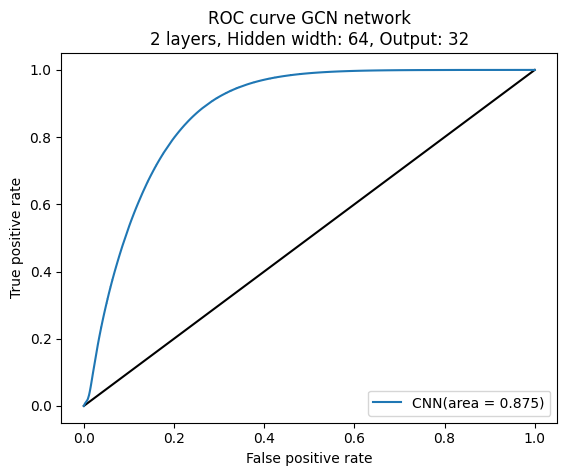

Final Test: 0.8773


In [12]:
# Train/Test Loop
best_val_auc = final_test_auc = 0
loss_collection = []
val_auc_collection = []
last_epoch = 30
for epoch in range(1, last_epoch + 1):
    if epoch > 5:
        rate_of_change_in_loss_e = [loss_collection[-i]-loss_collection[-i-1] for i in range(1,3)]
        rate_of_change_in_val_e = [val_auc_collection[-i]-val_auc_collection[-i-1] for i in range(1,3)]
        rate_of_change_in_loss = sum(rate_of_change_in_loss_e)/len(rate_of_change_in_loss_e)
        rate_of_change_in_val = sum(rate_of_change_in_val_e)/len(rate_of_change_in_val_e)
        if rate_of_change_in_loss * -1 > 0:
            if rate_of_change_in_val * -1 > 0:
                y_true = all_labels[0]
                y_pred = all_out[0]

                fpr, tpr, _ = roc_curve(y_true, y_pred)
                roc_auc = roc_auc_score(y_true, y_pred)

                plt.figure(1)
                plt.plot([0, 1], [0, 1], 'k-')
                plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
                plt.xlabel('False positive rate')
                plt.ylabel('True positive rate')
                plt.title('ROC curve GCN network\n2 layers, Hidden width: 64, Output: 32')
                plt.legend(loc='best')
                plt.show()
                break
    loss = train(train_loader, epoch)
    val_auc, _, _ = test(val_loader)
    test_auc, all_labels, all_out = test(test_loader)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')
    loss_collection.append(loss)
    val_auc_collection.append(val_auc)
    if epoch == last_epoch:
        y_true = all_labels[0]
        y_pred = all_out[0]

        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_pred)

        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k-')
        plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve GCN network\n2 layers, Hidden width: 64, Output: 32')
        plt.legend(loc='best')
        plt.show()


print(f'Final Test: {final_test_auc:.4f}')

In [ ]:
torch.save(model_ed, 'encoder_decoder_2.pth')

<h3>Validate encoding</h3>

In [7]:
model_ed = torch.load('encoder_decoder_2.pth')

<h3>Prepare data for clasification task</h3>

In [13]:
indices = [i for i in range(len(data_list))]

encodings_dict = {}
targets_dict = {"positives": [], "negatives": []}


max_count = 2000
cnt = 0

f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar
for graph_idx in sample(indices, max_count):
    graph = data_list[graph_idx]
    ng_matrix = graph.y.tolist()
    graph_x = graph.x
    encoding_matrix = model_ed.encode(graph_x, graph.edge_index).tolist()
    graph_x = graph_x.tolist()
    for i in range(1,101):
        encode_i = encoding_matrix[i]
        node_i = graph_x[i]
        new_entry = encode_i + node_i
        new_entry = ["%.5f" % e for e in new_entry]
        new_entry = [float(e) for e in new_entry]
        encodings_dict[graph_idx, i] = new_entry
        for j in range(1,101):
            if i != j:
                target = int(ng_matrix[i][j])
                if target == 1:
                    targets_dict["positives"].append((graph_idx, i, j))
                else:
                    targets_dict["negatives"].append((graph_idx, i, j))
    f.value += 1
    cnt += 1

IntProgress(value=0, max=2000)

In [25]:
max_veh = -1
min_veh = 1000
max_cap = -1
min_cap = 2000
for k,v in instance_additionals.items():
    if float(v[0][0]) > max_veh:
        max_veh = float(v[0][0])
    if float(v[0][0]) < min_veh:
        min_veh = float(v[0][0])
    if float(v[0][1]) > max_cap:
        max_cap = float(v[0][1])
    if float(v[0][1]) < min_cap:
        min_cap = float(v[0][1])

In [15]:
pos_candidates = sample(targets_dict["positives"], 200000)
neg_candidates = sample(targets_dict["negatives"], 200000)
pos_list = [[aux_data_list[k[0]][0][0]] + [aux_data_list[k[0]][0][1]] + encodings_dict[k[0], k[1]] + encodings_dict[k[0], k[2]] + [1] for k in pos_candidates]
neg_list = [[aux_data_list[k[0]][0][0]] + [aux_data_list[k[0]][0][1]] + encodings_dict[k[0], k[1]] + encodings_dict[k[0], k[2]] + [0] for k in neg_candidates]

In [16]:
targets_dict = {}

In [17]:
pre_tensor = pos_list + neg_list
main_tensor = torch.tensor(pre_tensor, dtype=torch.float32)

main_tensor = main_tensor[torch.randperm(main_tensor.size()[0])]
labels = main_tensor[:,-1:]
embeddings = main_tensor[:,:-1]

<h3>Classification model</h3>

In [18]:
class Deep4(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(78, 78) #142
        self.act1 = nn.ReLU()
        # self.layer1_1 = nn.Linear(284, 142)
        # self.act1_1 = nn.ReLU()
        self.layer2 = nn.Linear(78, 40)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(40, 40)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(40, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        # x = self.act1_1(self.layer1_1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [19]:
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # optimizer = optim.SGD(model.parameters(), lr=0.001)
 
    n_epochs = 60   # number of epochs to run
    batch_size = 500  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    loss_collection = []
    val_auc_collection = []
 
    for epoch in range(1,n_epochs+1):
        if epoch > 5:
            rate_of_change_in_loss_e = [loss_collection[-i]-loss_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_val_e = [val_auc_collection[-i]-val_auc_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_loss = sum(rate_of_change_in_loss_e)/len(rate_of_change_in_loss_e)
            rate_of_change_in_val = sum(rate_of_change_in_val_e)/len(rate_of_change_in_val_e)
            if rate_of_change_in_loss * -1 > 0:
                if rate_of_change_in_val * -1 > 0:
                    y_true = y_val
                    y_pred = y_pred

                    fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
                    roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

                    plt.figure(1)
                    plt.plot([0, 1], [0, 1], 'k-')
                    plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
                    plt.xlabel('False positive rate')
                    plt.ylabel('True positive rate')
                    plt.title('ROC curve Classification network\n3 layers, Hidden width: 40, Output: 1')
                    plt.legend(loc='best')
                    plt.show()
                    break
        if epoch == 30:
            for g in optimizer.param_groups:
                g['lr'] = 0.0001
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        loss_collection.append(loss)
        val_auc_collection.append(roc_auc_score(y_val, y_pred.detach().numpy()))
        if epoch == n_epochs:
            y_true = y_val
            y_pred = y_pred

            fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
            roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

            plt.figure(1)
            plt.plot([0, 1], [0, 1], 'k-')
            plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve Classification network\n3 layers, Hidden width: 40, Output: 1')
            plt.legend(loc='best')
            plt.show()
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [20]:
# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, train_size=0.7, shuffle=True)

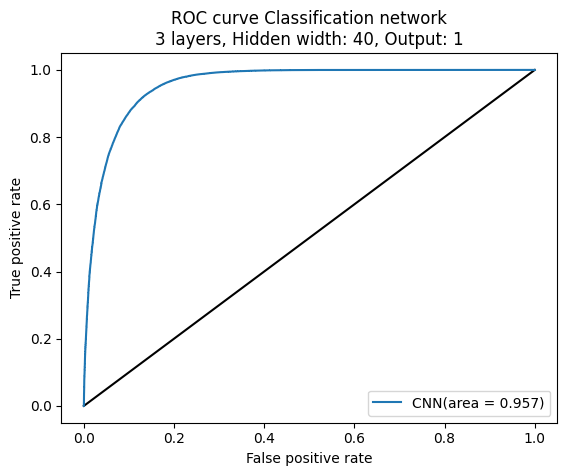

Final model accuracy: 89.55%


In [21]:
model_ls = Deep4()
acc = model_train(model_ls, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

In [36]:
torch.save(model_ls, 'classifier_3.pth')

<h3>Validate classification</h3>

In [13]:
model_ls=torch.load('classifier_2.pth')

In [22]:
instance_name = "JU3H000000.txt"
folder = ""
# ng_outs_file = "ng_outs_oct.csv"
# ng_outs_folder = ""

individual_instance = {}
instance_additionals = {}
with open(folder+instance_name, 'r') as text_file:
    cnt = 0
    instance = ""
    for line in text_file:
        if cnt < 9:
            if cnt == 0:
                instance = line.split()[0]
                individual_instance[instance] = []
            if cnt == 4:
                instance_additionals[instance] = []
                split_line = line.split()
                instance_additionals[instance].append([int(i) for i in split_line])
            cnt += 1
            continue
        split_line = line.split()
        individual_instance[instance].append([int(i) for i in split_line])
    text_file.close()

# ng_dict_aux = {}
# cnt = -1
# with open(ng_outs_folder+ng_outs_file, 'r') as text_file:
#     for line in text_file:
#         if cnt < 2:
#             cnt += 1
#             continue
#         raw_line = line.strip()
#         split_line_list = raw_line.split(sep=";")
#         instance = split_line_list[3]
#         if instance not in ng_dict_aux:
#             ng_dict_aux[instance] = [[0 for i in range(101)]]
#         ng_dict_aux[instance].append([0] + [int(i) for i in split_line_list[5:-1]])
#         if len(split_line_list[5:-1]) != 100:
#             print("case found for instance "+instance)
#     text_file.close()

In [23]:
instance_name = "JU3H000000"
instance = individual_instance[instance_name]
# y = torch.tensor(ng_dict_aux[instance_name], dtype=torch.float)
attr = []
for i in instance:
    attr.append(i[1:])
x = torch.nn.functional.normalize( torch.tensor(attr, dtype=torch.float) )
pos = []
tw_sets_dict = {}
for i in instance:
    pos.append([i[1], i[2]])
pos = torch.tensor(pos, dtype=torch.double)
edge_index = knn_graph(pos, 15)
raw_instance = Data(x=x, 
                    # y=y, 
                    edge_index=edge_index, 
                    pos=pos)

In [37]:
z_raw = model_ed.encode(raw_instance.x, raw_instance.edge_index)
preds = {}
additionals = instance_additionals[instance_name][0]
for i in range(1,201):
    for j in range(1,201):
        if i != j:
            node_i = z_raw[i].tolist() + raw_instance.x[i].tolist()
            node_j = z_raw[j].tolist() + raw_instance.x[j].tolist()
            # target = raw_instance.y[i][j]
            prediction = model_ls(torch.tensor([additionals[0], additionals[1]] + node_i+node_j, dtype=torch.float))
            preds[i,j] = {"pred":prediction}#,"target":target}

In [38]:
lista = []
for i in range(1,201):
    for j in range(1,201):
        if j != i:
            if preds[i,j]["pred"] > 0.2:
                lista.append((i,j))
print(len(lista)/(200*199))

0.2256532663316583
